# Problem $3$: Testing and training the transformer model

In this file we test and train the transformer model we implemented in problem $2$. 

In [15]:
from layers import *
from neural_network import NeuralNetwork
from utils import onehot
import numpy as np
import matplotlib.pyplot as plt
from data_generators import *
from training_utils import *

### $3.1$: Testing if the layers are implemented correctly
Here, we check that the functions implemented return matrices of the correct dimensions, and that the functions run. 

In [92]:
#We choose some arbitrary values for the dimensions
b = 6
n_max = 7
m = 8
n = 5

d = 10
k = 5
p = 20

#Create an arbitrary dataset
x = np.random.randint(0, m, (b,n))
y = np.random.randint(0, m, (b,n_max))

#initialize the layers
feed_forward = FeedForward(d,p)
attention = Attention(d,k)
embed_pos = EmbedPosition(n_max,m,d)
un_embed = LinearLayer(d,m)
softmax = Softmax()


#a manual forward pass
X = onehot(x, m)
z0 = embed_pos.forward(X)
z1 = feed_forward.forward(z0)
z2 = attention.forward(z1)
z3 = un_embed.forward(z2)
Z = softmax.forward(z3) 



#check the shapes
assert X.shape == (b,m,n), f"X.shape={X.shape}, expected {(b,m,n)}"
assert z0.shape == (b,d,n), f"z0.shape={z0.shape}, expected {(b,d,n)}"
assert z1.shape == (b,d,n), f"z1.shape={z1.shape}, expected {(b,d,n)}"
assert z2.shape == (b,d,n), f"z2.shape={z2.shape}, expected {(b,d,n)}"
assert z3.shape == (b,m,n), f"z3.shape={z3.shape}, expected {(b,m,n)}"
assert Z.shape == (b,m,n), f"Z.shape={Z.shape}, expected {(b,m,n)}"

#is X one-hot?
assert X.sum() == b*n, f"X.sum()={X.sum()}, expected {b*n}"


assert np.allclose(Z.sum(axis=1), 1), f"Z.sum(axis=1)={Z.sum(axis=1)}, expected {np.ones(b)}"
assert np.abs(Z.sum() - b*n) < 1e-5, f"Z.sum()={Z.sum()}, expected {b*n}"
assert np.all(Z>=0), f"Z={Z}, expected all entries to be non-negative"

"""
Passes all checks
"""

Now that we know all matrices are of correct dimension, we check that we can do a forward and backward pass, and that $\texttt{step\_gd()}$ works. In essence, checking if the system learns. We print $L$ for every $1000$ iteration, to check that the loss function continues to decrease. 

In [94]:
#test the forward pass
n_y = n_max - 1
x = np.random.randint(0, m, (b,n_max))
X = onehot(x, m)

#we test with a y that is shorter than the maximum length
y = np.random.randint(0, m, (b,n_y))

#initialize a neural network based on the layers above
network = NeuralNetwork([embed_pos, feed_forward, attention, un_embed, softmax])
#and a loss function
loss = CrossEntropy()

N = 10000
#do a forward pass
for i in range(N):
    Z = network.forward(X)

    #compute the loss
    L = loss.forward(Z, y)
    if not (i%(N//10)):
        print(f"L number {i} is {L:.7f}")

    #get the derivative of the loss wrt Z
    grad_Z = loss.backward()

    #and perform a backward pass
    _ = network.backward(grad_Z)

    #and and do a gradient descent step
    _ = network.step_gd(0.1)

L number 0 is 13.5356492
L number 1000 is 0.0001030
L number 2000 is 0.0000446
L number 3000 is 0.0000276
L number 4000 is 0.0000197
L number 5000 is 0.0000151
L number 6000 is 0.0000122
L number 7000 is 0.0000102
L number 8000 is 0.0000088
L number 9000 is 0.0000076


In [20]:
nBatches = 10
batchSize = 250
n_max = 9
m = 8
n_iter = 500
feed_forward1O = FeedForward(d,p)
attention1O = Attention(d,k)
feed_forward2O = FeedForward(d,p)
attention2O = Attention(d,k)
embed_pos1O = EmbedPosition(n_max,m,d)
un_embed1O = LinearLayer(d,m)
softmax1O = Softmax()
network1O = NeuralNetwork([embed_pos1O, feed_forward1O, attention1O, feed_forward2O, attention2O, un_embed1O, softmax1O])
loss1O = CrossEntropy()
dataSet1O = generateSortData(nBatches, batchSize, n_max, m)
network1O,L = training(network1O, loss1O, dataSet1O, n_iter, m, alpha = 0.001)


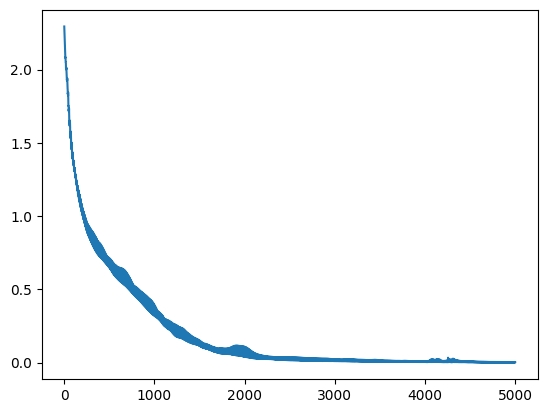

0.002206258977819866
97.5


In [21]:
fig, ax = plt.subplots()
ax.plot(np.arange(0,len(L),1), L)
plt.show()
print(L[-1])
N = 1000
y = np.random.randint(0,m,(N,5))
s = np.copy(y)
s = np.sort(s, axis = 1)
for i in range(5):
    z = np.argmax(network1O.forward(onehot(y,m)), axis = 1)
    y = np.append(y, z[:,-1:], axis = 1)
y = y[:,5:]
t = 0
for i in range(len(s)):
    equal = True
    for j in range(len(s[i])):
        if s[i,j] != y[i,j]:
            equal = False
    if equal:
        t += 1
print(t/N*100)

In [95]:
nBatches = 10
batchSize = 250
length = 5
n_max = 9
m = 8
n_iter = 500
d = 10
k = 5
p = 15

feed_forward1D = FeedForward(d,p)
attention1D = Attention(d,k)
feed_forward2D = FeedForward(d,p)
attention2D = Attention(d,k)
embed_pos1D = EmbedPosition(n_max,m,d)
un_embed1D = LinearLayer(d,m)
softmax1D = Softmax()
network1D = NeuralNetwork([embed_pos1D, feed_forward1D, attention1D, feed_forward2D, attention2D, un_embed1D, softmax1D])
loss1D = CrossEntropy()
dataAndTrain1D = get_train_test_sorting(length, m, batchSize, nBatches, n_batches_test=1)
dataSet1D = [dataAndTrain1D["x_train"], dataAndTrain1D["y_train"]]
network,L = training(network1D, loss1D, dataSet1D, n_iter, m, alpha = 0.001)
fig, ax = plt.subplots()
ax.plot(np.arange(0,np.size(L),1), L)
plt.show()
print(L[-1])
y = np.copy(dataAndTrain1D["x_test"][0])
for i in range(5):
    z = np.argmax(network1D.forward(onehot(y,m)), axis = 1)
    y = np.append(y, z[:,-1:], axis = 1)
t = 0
s = np.copy(dataAndTrain1D["y_test"][0])
y = y[:,5:]
for i in range(np.shape(s)[0]):
    equal = True
    for j in range(np.shape(s)[1]):
        if s[i,j] != y[i,j]:
            equal = False
    if equal:
        t += 1
print(t/np.shape(y)[0]*100)

In [23]:
"""
Here you may add additional tests to for example:

- Check if the ['d'] keys in the parameter dictionaries are not None, or receive something when running backward pass
- Check if the parameters change when you perform a gradient descent step
- Check if the loss decreases when you perform a gradient descent step

This is voluntary, but could be useful.
"""

"\nHere you may add additional tests to for example:\n\n- Check if the ['d'] keys in the parameter dictionaries are not None, or receive something when running backward pass\n- Check if the parameters change when you perform a gradient descent step\n- Check if the loss decreases when you perform a gradient descent step\n\nThis is voluntary, but could be useful.\n"

In [24]:
#check if loss is non-negative
assert L[-1] >= 0, f"L={L}, expected L>=0"
assert grad_Z.shape == Z.shape, f"grad_Z.shape={grad_Z.shape}, expected {Z.shape}"

#check if onehot(y) gives zero loss
Y = onehot(y, m)
L = loss.forward(Y, y)
assert L < 1e-5, f"L={L}, expected L<1e-5"


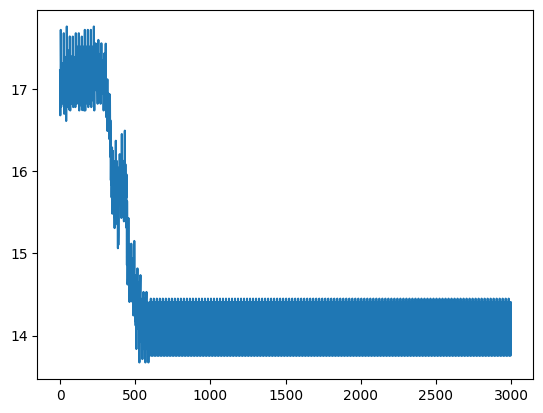

L:  14.368130980282848 


0.0 %
0.0 %
0.0 %
0.0 %


In [91]:
n_max = 6
m = 10
n_iter = 150

d = 30
k = 20
p = 40

samples_per_batch = 150
n_batches_train = 20
n_batches_test = 4

feed_forward1_add = FeedForward(d,p)
attention1_add = Attention(d,k)
feed_forward2_add = FeedForward(d,p)
attention2_add = Attention(d,k)
feed_forward3_add = FeedForward(d,p)
attention3_add = Attention(d,k)
embed_pos_add = EmbedPosition(n_max,m,d)
un_embed_add = LinearLayer(d,m)
softmax_add = Softmax()
network_add = NeuralNetwork([embed_pos_add, feed_forward1_add, attention1_add, feed_forward2_add, attention2_add, feed_forward3_add, attention3_add, un_embed_add, softmax_add])
loss_add = CrossEntropy()
dataSet = get_train_test_addition(n_digit=2, samples_per_batch = samples_per_batch, n_batches_train = n_batches_train, n_batches_test = n_batches_test)
data = [dataSet['x_train'],dataSet['y_train']]
network_add, L = training(network_add, loss_add, data, n_iter, m, alpha = 0.001)

fig, ax = plt.subplots()
ax.plot(np.arange(0,len(L),1), L)
plt.show()
print("L: ", L[-1], "\n\n")

t = 0

for batch_number in range(n_batches_test):

    x_arr = dataSet['x_test'][batch_number]

    for i in range(3):
        z = np.argmax(network_add.forward(onehot(x_arr,m)), axis = 1)
        x_arr = np.append(x_arr, z[:,-1:], axis = 1)

    for x in range(samples_per_batch):

        useful_x_values = x_arr[x,-3:]

        equal = True

        for digit in range(3):
            if useful_x_values[-(1+digit)]!=dataSet['y_test'][batch_number,x,digit]:
                equal = False

        if equal:
            t+=1
        
    print(t/(samples_per_batch*(batch_number+1))*100, "%")
